In [1]:
import psycopg2

from sqlalchemy import create_engine
from sqlalchemy import text

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
database_host='localhost'

In [3]:
def get_connection(host = "localhost",schema="" ):
    
    conn = psycopg2.connect("dbname='proj001_lfb' user='postgres' "
                            "host=" + host )
    if schema:
        cur = conn.cursor()
        query = "SET search_path TO {}".format(schema)
        cur.execute(query)

    return conn

# Create a feature dataset

## Incidents

In [4]:
conn = get_connection(host=database_host)
qry = ("select incidents.*, types.incidentgroup, types.stopcodedescription "
          "from proj001_lfb_1_0_0.l3_incidents incidents "
           "left join "
           "proj001_lfb_1_0_0.l3_incident_types types "
           "on "
           "incidents.id_incident_type = types.id"
          ";")
#data = pd.read_sql(qry, conn).drop(['store_no','store_type'], axis=1)  
df_incidents = pd.read_sql(qry, conn)  
conn.close()

# drop some columns that won't be features
df_incidents.drop(['num_stations_with_pumps_attending', 'num_pumps_attending'], axis =1 ,inplace=True)
df_incidents.head()

,id,incidentnumber_cln,dateofcall_cln,id_incident_type,id_property,id_postcode,incident_station_ground,incidentgroup,stopcodedescription
0,1,79398141,2014-06-22 10:21:15,2,24,108386,OVERTHEBORDER,False Alarm,False alarm - Good intent
1,2,168174131,2013-12-07 04:29:07,6,24,108387,OVERTHEBORDER,Fire,Primary Fire
2,3,168954111,2011-10-16 12:20:54,1,32,108388,BROMLEY,False Alarm,AFA
3,4,168866-17122017,2017-12-17 13:06:19,1,29,108388,BROMLEY,False Alarm,AFA
4,5,167600111,2011-10-14 11:58:03,1,24,108388,BROMLEY,False Alarm,AFA


## Postcodes

In [5]:
conn = get_connection(host=database_host)
qry = ('select *'
          'from proj001_lfb_1_0_0.l3_postcodes '
          ';')
#data = pd.read_sql(qry, conn).drop(['store_no','store_type'], axis=1)  
df_postcodes = pd.read_sql(qry, conn)  
conn.close()
df_postcodes.head()
conn.close()

Here we discover that fields may need to be stripped of trailing spaces in the pipeline code and that a proportion of the postcodes are unlabelled.

In [6]:
df_empty_pcodes = df_postcodes[df_postcodes['incgeo_boroughname']
             .map(lambda x: x.strip()) == 'NOT GEO-CODED'][['postcode_full','incgeo_boroughname']]['postcode_full'].unique()
print("Unlabeled postcodes: " + str(len(pd.DataFrame(df_empty_pcodes)) ))
print("Total postcodes: " + str(len(df_postcodes) ))

Unlabeled postcodes: 1669
Total postcodes: 110157


In [7]:
df_postcodes.drop(['postcode_district','incgeo_wardname','incgeo_wardnamenew'], inplace=True, axis =1 )
df_postcodes.head(2)

,id,postcode_full,incgeo_boroughname,frs
0,1,AL1 3EA,NOT GEO-CODED,OVERTHEBORDER
1,2,AL2 1QY,NOT GEO-CODED,OVERTHEBORDER


## Property details

In [8]:
conn = get_connection(host=database_host)
qry = ('select *'
          'from proj001_lfb_1_0_0.l3_property '
          ';')
#data = pd.read_sql(qry, conn).drop(['store_no','store_type'], axis=1)  
df_property = pd.read_sql(qry, conn)  
conn.close()
df_property.head(3)

,id,propertycategory,propertytype
0,1,Aircraft,Freight plane
1,2,Aircraft,Helicopter
2,3,Aircraft,Light aircraft


# Features dataset
Join together the relevant datasets and drop unnecessary columns.

In [9]:
df_features = pd.merge(pd.merge(df_incidents,df_postcodes,left_on='id_postcode',right_on='id', how='left') , 
                       df_property,left_on='id_property',right_on='id',how='left')
df_features.drop(['id','id_y'], inplace=True, axis =1)
df_features.head()

,id_x,incidentnumber_cln,dateofcall_cln,id_incident_type,id_property,id_postcode,incident_station_ground,incidentgroup,stopcodedescription,postcode_full,incgeo_boroughname,frs,propertycategory,propertytype
0,1,79398141,2014-06-22 10:21:15,2,24,108386,OVERTHEBORDER,False Alarm,False alarm - Good intent,None,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy
1,2,168174131,2013-12-07 04:29:07,6,24,108387,OVERTHEBORDER,Fire,Primary Fire,None,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy
2,3,168954111,2011-10-16 12:20:54,1,32,108388,BROMLEY,False Alarm,AFA,None,BROMLEY,LONDON,Dwelling,Self contained Sheltered Housing
3,4,168866-17122017,2017-12-17 13:06:19,1,29,108388,BROMLEY,False Alarm,AFA,None,BROMLEY,LONDON,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys
4,5,167600111,2011-10-14 11:58:03,1,24,108388,BROMLEY,False Alarm,AFA,None,BROMLEY,LONDON,Dwelling,House - single occupancy


Reorder columns into tidydata format

In [10]:
df_features.columns.tolist
cols = ['id_x', 'dateofcall_cln','incidentnumber_cln', 'id_incident_type',
       'id_property', 'id_postcode', 'incident_station_ground',
     'postcode_full',
       'incgeo_boroughname', 'frs', 'propertycategory', 'propertytype', 'incidentgroup','stopcodedescription']
df_features=df_features[cols]
df_features.head()

,id_x,dateofcall_cln,incidentnumber_cln,id_incident_type,id_property,id_postcode,incident_station_ground,postcode_full,incgeo_boroughname,frs,propertycategory,propertytype,incidentgroup,stopcodedescription
0,1,2014-06-22 10:21:15,79398141,2,24,108386,OVERTHEBORDER,None,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy,False Alarm,False alarm - Good intent
1,2,2013-12-07 04:29:07,168174131,6,24,108387,OVERTHEBORDER,None,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy,Fire,Primary Fire
2,3,2011-10-16 12:20:54,168954111,1,32,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,Self contained Sheltered Housing,False Alarm,AFA
3,4,2017-12-17 13:06:19,168866-17122017,1,29,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,False Alarm,AFA
4,5,2011-10-14 11:58:03,167600111,1,24,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,House - single occupancy,False Alarm,AFA


# Create the event label
First let's look at the different types of false alarms. AFA is an automatic alarm system. 

In [11]:
df_features[['incidentgroup','stopcodedescription']].drop_duplicates().sort_values(by='incidentgroup')

,incidentgroup,stopcodedescription
0,False Alarm,False alarm - Good intent
2,False Alarm,AFA
65,False Alarm,False alarm - Malicious
1,Fire,Primary Fire
14,Fire,Chimney Fire
571,Fire,Secondary Fire
3127,Fire,Late Call
452853,NULL,NULL
11,Special Service,Special Service
42,Special Service,Flood call attended - Batch mobilised


NULL alarm types are not significant so we will drop them

In [12]:
df_null_incidents=df_features.groupby(['incidentgroup','stopcodedescription']).count().reset_index()
print("Rows before drop: " + str(len(df_features)))
df_features=df_features.drop(df_features[df_features['incidentgroup'] == 'NULL'].index)
print("Rows after drop: " + str(len(df_features)))

Rows before drop: 993030
Rows after drop: 993027


Create the label variable

In [13]:
df_features['is_malicious_false_alarm'] = np.where(df_features['stopcodedescription'] == 'False alarm - Malicious', 1,0)
df_features[['incidentgroup','stopcodedescription','is_malicious_false_alarm']].drop_duplicates().sort_values(by='incidentgroup')


,incidentgroup,stopcodedescription,is_malicious_false_alarm
0,False Alarm,False alarm - Good intent,0
2,False Alarm,AFA,0
65,False Alarm,False alarm - Malicious,1
1,Fire,Primary Fire,0
14,Fire,Chimney Fire,0
571,Fire,Secondary Fire,0
3127,Fire,Late Call,0
11,Special Service,Special Service,0
42,Special Service,Flood call attended - Batch mobilised,0
36700,Special Service,Use of Special Operations Room,0


# Create derived variables

In [14]:
df_features['incident_month']=df_features['dateofcall_cln'].dt.month
df_features['incident_year']=df_features['dateofcall_cln'].dt.year
df_features['incident_hour']=df_features['dateofcall_cln'].dt.hour
df_features['incident_day']=df_features['dateofcall_cln'].dt.dayofweek

def is_weekend(df):
    """Determine if a callout was at the weekend. By weekend we really mean from Friday evening onwards"""
    
    if df['incident_day'] == 6 or df['incident_day'] == 5:
        return 1
    elif df['incident_day'] == 4 and df['incident_hour']>=18:
        return 1 
    else:
        return 0
    
df_features['is_weekend'] = df_features.apply(is_weekend,axis =1)
print(df_features.dtypes)
df_features.head()

id_x                                 int64
dateofcall_cln              datetime64[ns]
incidentnumber_cln                  object
id_incident_type                     int64
id_property                          int64
id_postcode                          int64
incident_station_ground             object
postcode_full                       object
incgeo_boroughname                  object
frs                                 object
propertycategory                    object
propertytype                        object
incidentgroup                       object
stopcodedescription                 object
is_malicious_false_alarm             int64
incident_month                       int64
incident_year                        int64
incident_hour                        int64
incident_day                         int64
is_weekend                           int64
dtype: object


,id_x,dateofcall_cln,incidentnumber_cln,id_incident_type,id_property,id_postcode,incident_station_ground,postcode_full,incgeo_boroughname,frs,propertycategory,propertytype,incidentgroup,stopcodedescription,is_malicious_false_alarm,incident_month,incident_year,incident_hour,incident_day,is_weekend
0,1,2014-06-22 10:21:15,79398141,2,24,108386,OVERTHEBORDER,None,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy,False Alarm,False alarm - Good intent,0,6,2014,10,6,1
1,2,2013-12-07 04:29:07,168174131,6,24,108387,OVERTHEBORDER,None,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy,Fire,Primary Fire,0,12,2013,4,5,1
2,3,2011-10-16 12:20:54,168954111,1,32,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,Self contained Sheltered Housing,False Alarm,AFA,0,10,2011,12,6,1
3,4,2017-12-17 13:06:19,168866-17122017,1,29,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,False Alarm,AFA,0,12,2017,13,6,1
4,5,2011-10-14 11:58:03,167600111,1,24,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,House - single occupancy,False Alarm,AFA,0,10,2011,11,4,0


Weekends or particular times of night might be a good predictor of malicious false alarms.

In [15]:
df_events=df_features.groupby(['is_malicious_false_alarm','incident_day'])['is_malicious_false_alarm'].count()
print(df_events)


is_malicious_false_alarm  incident_day
0                         0               137478
                          1               138124
                          2               136820
                          3               139160
                          4               141587
                          5               146109
                          6               137959
1                         0                 2112
                          1                 2143
                          2                 2081
                          3                 2216
                          4                 2275
                          5                 2542
                          6                 2421
Name: is_malicious_false_alarm, dtype: int64


Here is a sample of when malicious false alarms happen. There seem to be more malicious calls on weekends than during the week.

65     0
105    0
141    3
212    0
247    1
Name: incident_day, dtype: int64


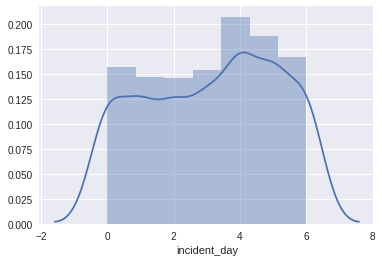

In [16]:
df_plot=df_features.loc[ df_features['is_malicious_false_alarm']==1 ]['incident_day']
print(df_plot.head())

chosen_idx = np.random.choice(len(df_plot), replace=False, size=1000)
df_plot = df_plot.iloc[chosen_idx]

sns.distplot(df_plot, hist=True, rug=False,bins=7);

0    6
1    5
2    6
3    6
4    4
Name: incident_day, dtype: int64


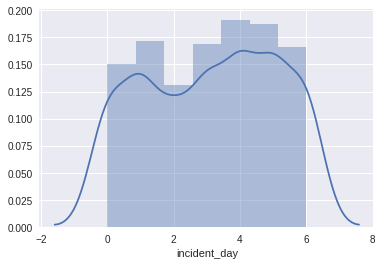

In [17]:
df_plot=df_features.loc[ df_features['is_malicious_false_alarm']==0 ]['incident_day']
print(df_plot.head())

chosen_idx = np.random.choice(len(df_plot), replace=False, size=1000)
df_plot = df_plot.iloc[chosen_idx]

sns.distplot(df_plot, hist=True, rug=False,bins=7);

# Is hour of day a good predictor?
It doesn't seem like hour of day is a good predictor

65      2
105    16
141    19
212    16
247     2
Name: incident_hour, dtype: int64


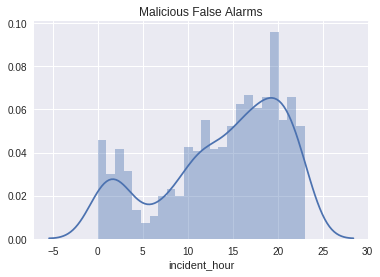

In [18]:
df_plot=df_features.loc[ df_features['is_malicious_false_alarm']==1 ]['incident_hour']
print(df_plot.head())

chosen_idx = np.random.choice(len(df_plot), replace=False, size=1000)
df_plot = df_plot.iloc[chosen_idx]

plt=sns.distplot(df_plot, bins=24,hist=True, rug=False);
plt.set_title('Malicious False Alarms')

0    10
1     4
2    12
3    13
4    11
Name: incident_hour, dtype: int64


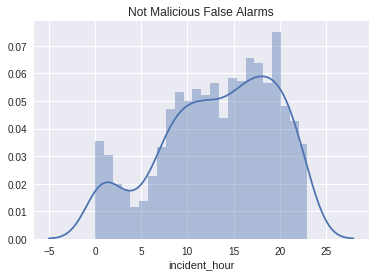

In [19]:
df_plot=df_features.loc[ df_features['is_malicious_false_alarm']==0 ]['incident_hour']
print(df_plot.head())

chosen_idx = np.random.choice(len(df_plot), replace=False, size=1000)
df_plot = df_plot.iloc[chosen_idx]

plt=sns.distplot(df_plot, bins=24,hist=True, rug=False);
plt.set_title('Not Malicious False Alarms')

# Save features dataset
This dataset was time consuming to create. We might like to pick up our work from here so let's save the dataset to the workproduct namespace. 
Note that the namespace for these datasets is the same as the workproduct ID and version number. 

In [20]:
import psycopg2
import sqlalchemy

database_host='localhost'
engine = create_engine('postgresql://postgres@'+database_host+':5432/proj001_lfb')
conn = engine.connect()

sql = text('drop schema if exists wp_005_false_alarm_analysis_01 cascade;')
conn.execute(sql)

sql = text('create schema if not exists wp_005_false_alarm_analysis_01;' )
conn.execute(sql)

In [21]:
df_features.to_sql(name='df_features',con= conn,schema ='wp_005_false_alarm_analysis_01')

SystemError: <built-in function utf_8_encode> returned a result with an error set

In [24]:
conn.close()

# Prepare data for algorithm

First retrieve the features dataset from our datastore

*Note:* something wrong when dataset is read back in. Algortihm fitting and tuning seems to fail

In [53]:
engine = create_engine('postgresql://postgres@'+database_host+':5432/proj001_lfb')
conn = engine.connect()

sql = "select * from wp_005_false_alarm_analysis_01.df_features;"
df_features = pd.read_sql(sql,conn)
df_features.set_index('index',inplace=True)
df_features.head()
print(df_features.dtypes)


level_0                              int64
id_x                                 int64
dateofcall_cln              datetime64[ns]
incidentnumber_cln                  object
id_incident_type                     int64
id_property                          int64
id_postcode                          int64
incident_station_ground             object
postcode_full                       object
incgeo_boroughname                  object
frs                                 object
propertycategory                    object
propertytype                        object
incidentgroup                       object
stopcodedescription                 object
is_malicious_false_alarm             int64
incident_month                       int64
incident_year                        int64
incident_hour                        int64
incident_day                         int64
dtype: object


In [23]:
print(df_features.dtypes)
#df_features.drop(['level_0','index'],inplace=True,axis=1)
df_features.head(10)

id_x                                 int64
dateofcall_cln              datetime64[ns]
incidentnumber_cln                  object
id_incident_type                     int64
id_property                          int64
id_postcode                          int64
incident_station_ground             object
postcode_full                       object
incgeo_boroughname                  object
frs                                 object
propertycategory                    object
propertytype                        object
incidentgroup                       object
stopcodedescription                 object
is_malicious_false_alarm             int64
incident_month                       int64
incident_year                        int64
incident_hour                        int64
incident_day                         int64
is_weekend                           int64
dtype: object


,id_x,dateofcall_cln,incidentnumber_cln,id_incident_type,id_property,id_postcode,incident_station_ground,postcode_full,incgeo_boroughname,frs,propertycategory,propertytype,incidentgroup,stopcodedescription,is_malicious_false_alarm,incident_month,incident_year,incident_hour,incident_day,is_weekend
0,1,2014-06-22 10:21:15,79398141,2,24,108386,OVERTHEBORDER,None,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy,False Alarm,False alarm - Good intent,0,6,2014,10,6,1
1,2,2013-12-07 04:29:07,168174131,6,24,108387,OVERTHEBORDER,None,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy,Fire,Primary Fire,0,12,2013,4,5,1
2,3,2011-10-16 12:20:54,168954111,1,32,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,Self contained Sheltered Housing,False Alarm,AFA,0,10,2011,12,6,1
3,4,2017-12-17 13:06:19,168866-17122017,1,29,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,False Alarm,AFA,0,12,2017,13,6,1
4,5,2011-10-14 11:58:03,167600111,1,24,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,House - single occupancy,False Alarm,AFA,0,10,2011,11,4,0
5,6,2010-12-05 16:40:52,205145101,1,32,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,Self contained Sheltered Housing,False Alarm,AFA,0,12,2010,16,6,1
6,7,2010-12-04 16:34:10,204529101,1,32,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,Self contained Sheltered Housing,False Alarm,AFA,0,12,2010,16,5,1
7,8,2010-11-29 03:30:21,201106101,1,32,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,Self contained Sheltered Housing,False Alarm,AFA,0,11,2010,3,0,0
8,9,2010-02-06 14:47:24,20245101,1,32,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,Self contained Sheltered Housing,False Alarm,AFA,0,2,2010,14,5,1
9,10,2014-02-17 13:20:43,20170141,1,24,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,House - single occupancy,False Alarm,AFA,0,2,2014,13,0,0


Drop columns and rows we won't need

In [24]:
df_algorithm = df_features.drop(['id_x','incidentnumber_cln','incident_station_ground','id_postcode','postcode_full','frs','dateofcall_cln','id_incident_type','id_property'],axis =1)

# Drop the label variables
df_algorithm = df_algorithm.drop(['incidentgroup','stopcodedescription'],axis=1)

print(df_algorithm.head(5))

df_algorithm=df_algorithm.dropna()

  incgeo_boroughname propertycategory  \
0      NOT GEO-CODED         Dwelling   
1      NOT GEO-CODED         Dwelling   
2            BROMLEY         Dwelling   
3            BROMLEY         Dwelling   
4            BROMLEY         Dwelling   

                                        propertytype  \
0                          House - single occupancy    
1                          House - single occupancy    
2                  Self contained Sheltered Housing    
3  Purpose Built Flats/Maisonettes - 4 to 9 storeys    
4                          House - single occupancy    

   is_malicious_false_alarm  incident_month  incident_year  incident_hour  \
0                         0               6           2014             10   
1                         0              12           2013              4   
2                         0              10           2011             12   
3                         0              12           2017             13   
4                         0    

## Prepare the training and test sets

### Need to encode all the categorical variables

In [25]:
# # TODO complete encoding first
# df_propertytype_one_hot = pd.get_dummies( df_algorithm['propertytype'])

df_algorithm.drop('propertytype', inplace=True,axis=1)
# df_algorithm=df_algorithm.join(df_propertytype_one_hot)

# df_algorithm.head()

In [26]:
# TODO complete encoding first
df_propertycategory_one_hot = pd.get_dummies( df_algorithm['propertycategory'])

df_algorithm.drop('propertycategory', inplace=True,axis=1)
df_algorithm=df_algorithm.join(df_propertycategory_one_hot)

df_algorithm.head()


,incgeo_boroughname,is_malicious_false_alarm,incident_month,incident_year,incident_hour,incident_day,is_weekend,Aircraft,Boat,Dwelling,Non Residential,Other Residential,Outdoor,Outdoor Structure,Rail Vehicle,Road Vehicle
0,NOT GEO-CODED,0,6,2014,10,6,1,0,0,1,0,0,0,0,0,0
1,NOT GEO-CODED,0,12,2013,4,5,1,0,0,1,0,0,0,0,0,0
2,BROMLEY,0,10,2011,12,6,1,0,0,1,0,0,0,0,0,0
3,BROMLEY,0,12,2017,13,6,1,0,0,1,0,0,0,0,0,0
4,BROMLEY,0,10,2011,11,4,0,0,0,1,0,0,0,0,0,0


In [27]:
df_borough_one_hot = pd.get_dummies( df_algorithm['incgeo_boroughname'])

df_algorithm.drop('incgeo_boroughname', inplace=True,axis=1)
df_algorithm=df_algorithm.join(df_borough_one_hot)

df_algorithm.head()

,is_malicious_false_alarm,incident_month,incident_year,incident_hour,incident_day,is_weekend,Aircraft,Boat,Dwelling,Non Residential,...,MERTON,NEWHAM,REDBRIDGE,RICHMOND UPON THAMES,SOUTHWARK,SUTTON,TOWER HAMLETS,WALTHAM FOREST,WANDSWORTH,WESTMINSTER
0,0,6,2014,10,6,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,12,2013,4,5,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,10,2011,12,6,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,12,2017,13,6,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,10,2011,11,4,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
df_algorithm.dtypes

level_0                     int64
is_malicious_false_alarm    int64
incident_month              int64
incident_year               int64
incident_hour               int64
incident_day                int64
Dwelling                    uint8
 NOT GEO-CODED              uint8
BROMLEY                     uint8
dtype: object

## Fit the model

In [28]:
X = df_algorithm.drop('is_malicious_false_alarm', axis=1)
y = df_algorithm['is_malicious_false_alarm']

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=101, shuffle=True)

/app/software/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [30]:
print(X_train.head())
print("")
print(y_train.head())

        incident_month  incident_year  incident_hour  incident_day  \
359944              10           2016              7             6   
651984               7           2017             23             0   
355513               3           2013             19             5   
96218                9           2015             15             0   
177354              10           2015             12             4   

        is_weekend  Aircraft  Boat  Dwelling  Non Residential  \
359944           1         0     0         1                0   
651984           0         0     0         0                0   
355513           1         0     0         1                0   
96218            0         0     0         1                0   
177354           0         0     0         1                0   

        Other Residential     ...       MERTON  NEWHAM  REDBRIDGE  \
359944                  0     ...            0       0          0   
651984                  0     ...            0    

In [31]:
from sklearn import tree

model = tree.DecisionTreeClassifier()
model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [32]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Test the model

In [33]:
y_predict = model.predict(X_test)

y_predict

array([0, 0, 0, ..., 0, 0, 0])

In [34]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_predict)

0.96947725647764926

In [42]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Not Malicious', 'Predicted Malicious'],
    index=['True Not Malicious', 'True Malicious']
)

,Predicted Not Malicious,Predicted Malicious
True Not Malicious,192426,3022
True Malicious,3040,118


## Stitch predictions back onto original dataset

In [47]:
df_results = X_test
df_results['predictions'] = y_predict
df_results.head(10)

/app/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,incident_month,incident_year,incident_hour,incident_day,is_weekend,Aircraft,Boat,Dwelling,Non Residential,Other Residential,...,NEWHAM,REDBRIDGE,RICHMOND UPON THAMES,SOUTHWARK,SUTTON,TOWER HAMLETS,WALTHAM FOREST,WANDSWORTH,WESTMINSTER,predictions
906065,10,2009,2,5,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
91226,2,2017,14,6,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
398220,10,2016,17,6,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
672391,4,2011,22,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
681742,1,2017,13,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95078,2,2014,2,6,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
64437,9,2017,22,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
935648,9,2012,14,5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
925040,9,2014,11,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
750665,2,2016,14,6,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
